**Title**: Flappy Bird Game

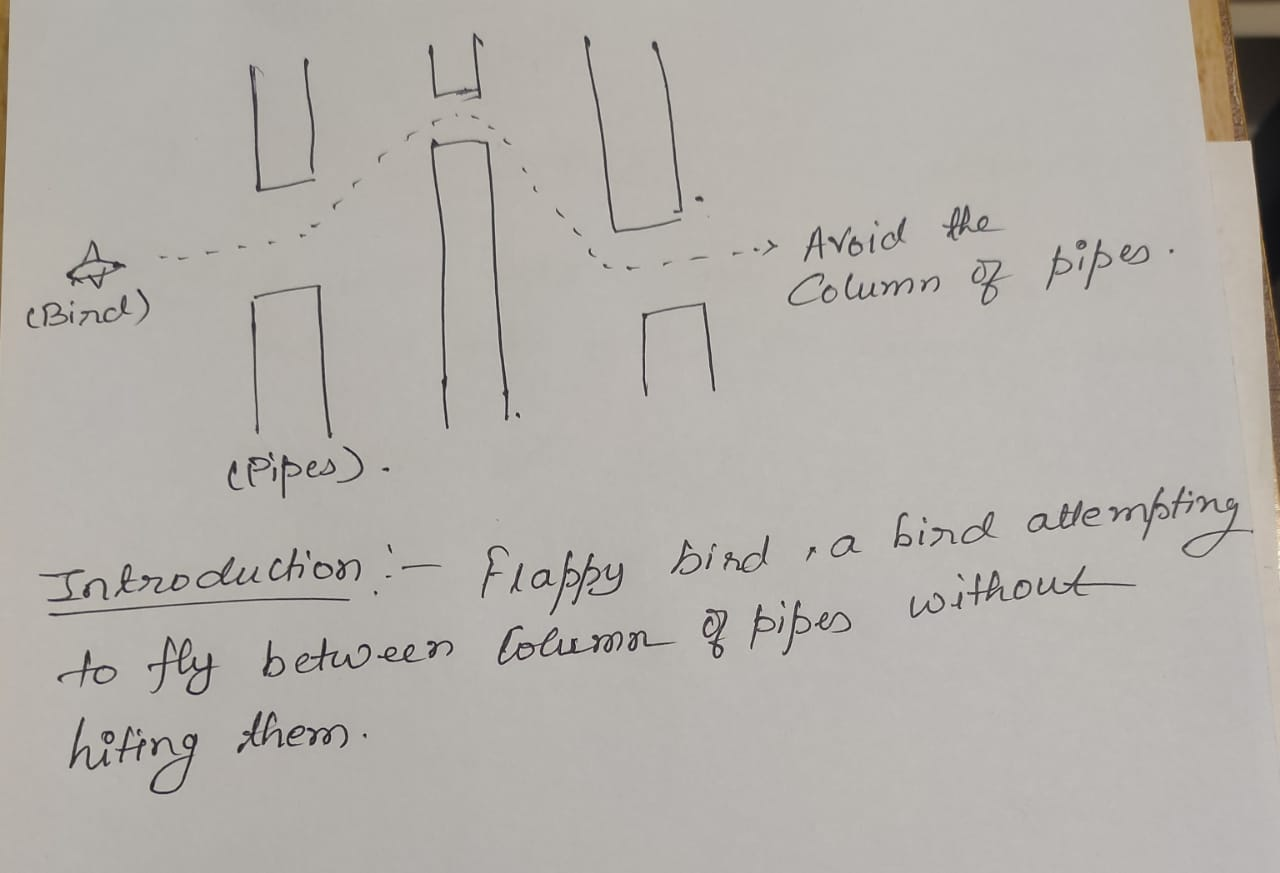

**Problem Statement:** Develop a Deep Q-Network (DQN) to play the game "Flappy Bird," aiming to maximize the bird's flight distance without hitting the pipes or the ground.

**Concept Sketch:**

**Requirements and Deliverables:**

Import all the libraries required for the project.

In [40]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras import layers

1.** Environment Setup:**
Define the game environment, including the state space, action space, rewards, and terminal conditions.

**State Space:**

Bird's vertical position
Horizontal distance to the next pipe
Gap height of the next pipe

**Action Space:**

Flap (fly up)
Do nothing (let gravity pull the bird down)

**Rewards:**

+1 for each time step the bird survives
-100 for colliding with a pipe or the ground
Terminal Conditions:

Collision with pipes or ground

In [41]:

# Constants
SCREEN_WIDTH = 400
SCREEN_HEIGHT = 600

class FlappyBirdEnv(gym.Env):
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(2)  # flap or not flap
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32)
        self.state = None

        # Pygame specific initializations (not used in Colab)
        self.pipe_width = 50
        self.pipe_gap = 150
        self.bird_radius = 10
        self.gravity = 0.25
        self.lift = -4
        self.bird_x = SCREEN_WIDTH // 4

        self.reset()

    def reset(self):
        self.bird_y = SCREEN_HEIGHT // 2
        self.bird_vel = 0
        self.pipes = []
        self.score = 0
        self.generate_pipe()
        self.state = self.get_state()
        return self.state

    def step(self, action):
        reward = 1
        done = False

        if action == 1:
            self.bird_vel = self.lift

        self.bird_vel += self.gravity
        self.bird_y += self.bird_vel

        if self.bird_y <= 0 or self.bird_y >= SCREEN_HEIGHT:
            done = True
            reward = -100

        self.move_pipes()
        self.generate_pipe()

        for pipe in self.pipes:
            if self.bird_x + self.bird_radius > pipe[0] and self.bird_x - self.bird_radius < pipe[0] + self.pipe_width:
                if self.bird_y - self.bird_radius < pipe[1] or self.bird_y + self.bird_radius > pipe[1] + self.pipe_gap:
                    done = True
                    reward = -100
                    break

        if not done:
            self.score += 1

        self.state = self.get_state()
        return self.state, reward, done, {}

    def generate_pipe(self):
        if len(self.pipes) == 0 or self.pipes[-1][0] < SCREEN_WIDTH - 200:
            pipe_y = random.randint(100, SCREEN_HEIGHT - 100 - self.pipe_gap)
            self.pipes.append([SCREEN_WIDTH, pipe_y])

    def move_pipes(self):
        for pipe in self.pipes:
            pipe[0] -= 2
        if self.pipes[0][0] < -self.pipe_width:
            self.pipes.pop(0)

    def get_state(self):
        if len(self.pipes) == 0:
            pipe_x, pipe_y = SCREEN_WIDTH, SCREEN_HEIGHT // 2
        else:
            pipe_x, pipe_y = self.pipes[0]
        return np.array([self.bird_y / SCREEN_HEIGHT, (pipe_x - self.bird_x) / SCREEN_WIDTH, pipe_y / SCREEN_HEIGHT], dtype=np.float32)






**2. Replay Buffer:**
Implement a replay buffer to store experiences (state, action, reward, next state, terminal flag).

In [42]:
class ReplayBuffer:
    def __init__(self, max_size=10000, batch_size=64):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


**3. Deep Q-Network Architecture:**
Design the neural network architecture for the DQN using Convolutional Neural Networks. The input to the network is the game state, and the output is the Q-values for each possible action.

**Epsilon-Greedy Exploration:**
Implement an exploration strategy such as epsilon-greedy to balance exploration (trying new actions) and exploitation (using learned knowledge).

In [43]:
class Agent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.replay_buffer = ReplayBuffer()
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.q_network = self.build_model()
        self.target_network = self.build_model()
        self.update_target_network()

    def build_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='mse')
        return model

    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))
        q_values = self.q_network(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self):
        if len(self.replay_buffer.buffer) < self.replay_buffer.batch_size:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample()
        target_q_values = self.target_network(next_states)
        max_target_q_values = np.max(target_q_values, axis=1)
        targets = rewards + (1 - dones) * 0.99 * max_target_q_values
        with tf.GradientTape() as tape:
            q_values = self.q_network(states)
            indices = np.arange(q_values.shape[0])
            actions = actions.astype(int)
            q_values = tf.gather_nd(q_values, np.stack([indices, actions], axis=1))
            loss = tf.keras.losses.MSE(targets, q_values)
        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.q_network.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))

        if np.random.rand() < 0.01:
            self.update_target_network()

In [44]:
# Training Function
def train_dqn(agent, env, n_episodes):
    rewards = []
    for e in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            agent.learn()
        agent.decay_epsilon()
        rewards.append(total_reward)
        print(f"Episode {e+1}/{n_episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    return rewards



**6. Testing and Evaluation:**
After training, evaluate the DQN by running it in the environment without exploration (set epsilon to 0). Monitor metrics such as average reward per episode, survival time, etc., to assess the performance.

In [45]:
# Evaluation Function (for evaluation without retraining)
def evaluate_dqn(agent, env, n_episodes):
    total_rewards = []
    for e in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(agent.q_network(np.expand_dims(state, axis=0))[0])
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {e+1}/{n_episodes}, Total Reward: {total_reward}")
    return total_rewards

In [46]:
if __name__ == "__main__":
    env = FlappyBirdEnv()
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = Agent(state_size, action_size)

    # Train the agent
    n_train_episodes = 500
    train_rewards = train_dqn(agent, env, n_train_episodes)

    # Save the trained model weights
    agent.q_network.save_weights('dqn_flappy_bird.h5')
    print("Saved trained model weights")


Episode 1/500, Total Reward: -15, Epsilon: 0.99
Episode 2/500, Total Reward: -14, Epsilon: 0.99
Episode 3/500, Total Reward: -16, Epsilon: 0.99
Episode 4/500, Total Reward: -14, Epsilon: 0.98
Episode 5/500, Total Reward: -16, Epsilon: 0.98
Episode 6/500, Total Reward: -15, Epsilon: 0.97
Episode 7/500, Total Reward: -14, Epsilon: 0.97
Episode 8/500, Total Reward: -12, Epsilon: 0.96
Episode 9/500, Total Reward: -14, Epsilon: 0.96
Episode 10/500, Total Reward: -15, Epsilon: 0.95
Episode 11/500, Total Reward: -16, Epsilon: 0.95
Episode 12/500, Total Reward: -15, Epsilon: 0.94
Episode 13/500, Total Reward: -14, Epsilon: 0.94
Episode 14/500, Total Reward: -10, Epsilon: 0.93
Episode 15/500, Total Reward: -14, Epsilon: 0.93
Episode 16/500, Total Reward: -14, Epsilon: 0.92
Episode 17/500, Total Reward: -17, Epsilon: 0.92
Episode 18/500, Total Reward: -13, Epsilon: 0.91
Episode 19/500, Total Reward: -16, Epsilon: 0.91
Episode 20/500, Total Reward: -16, Epsilon: 0.90
Episode 21/500, Total Reward:

In [47]:
# Assume agent and env are already initialized from Part 1

# Evaluation Function (for evaluation without retraining)
def evaluate_dqn(agent, env, n_episodes):
    total_rewards = []
    for e in range(n_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(agent.q_network(np.expand_dims(state, axis=0))[0])
            next_state, reward, done, _ = env.step(action)
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {e+1}/{n_episodes}, Total Reward: {total_reward}")
    return total_rewards

# Main Evaluation and Visualization
if __name__ == "__main__":
    # Load the trained model weights
    agent.q_network.load_weights('dqn_flappy_bird.h5')

    # Evaluate the agent
    n_eval_episodes = 50  # Number of episodes to evaluate
    evaluation_rewards = evaluate_dqn(agent, env, n_eval_episodes)

Evaluation Episode 1/50, Total Reward: 61
Evaluation Episode 2/50, Total Reward: 45
Evaluation Episode 3/50, Total Reward: 69
Evaluation Episode 4/50, Total Reward: 62
Evaluation Episode 5/50, Total Reward: 45
Evaluation Episode 6/50, Total Reward: 60
Evaluation Episode 7/50, Total Reward: 72
Evaluation Episode 8/50, Total Reward: 45
Evaluation Episode 9/50, Total Reward: 70
Evaluation Episode 10/50, Total Reward: 45
Evaluation Episode 11/50, Total Reward: 45
Evaluation Episode 12/50, Total Reward: 59
Evaluation Episode 13/50, Total Reward: 78
Evaluation Episode 14/50, Total Reward: 146
Evaluation Episode 15/50, Total Reward: 75
Evaluation Episode 16/50, Total Reward: 61
Evaluation Episode 17/50, Total Reward: 45
Evaluation Episode 18/50, Total Reward: 64
Evaluation Episode 19/50, Total Reward: 45
Evaluation Episode 20/50, Total Reward: 146
Evaluation Episode 21/50, Total Reward: 45
Evaluation Episode 22/50, Total Reward: 146
Evaluation Episode 23/50, Total Reward: 72
Evaluation Episod

     Plot for training and evaluation rewards

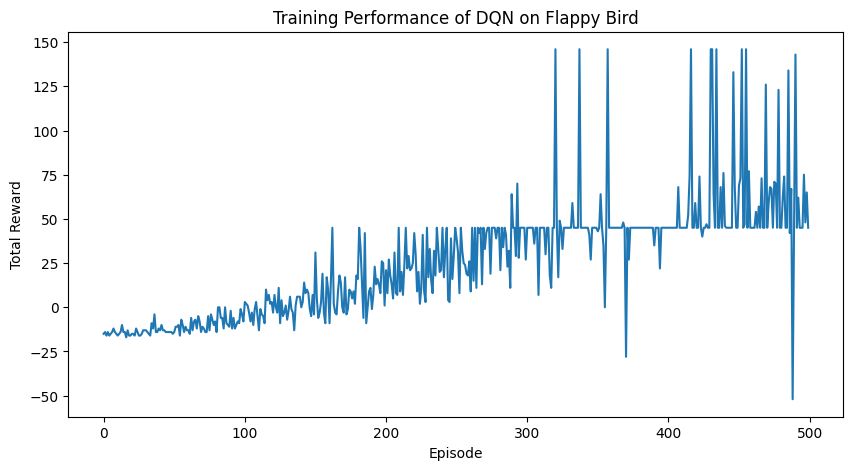

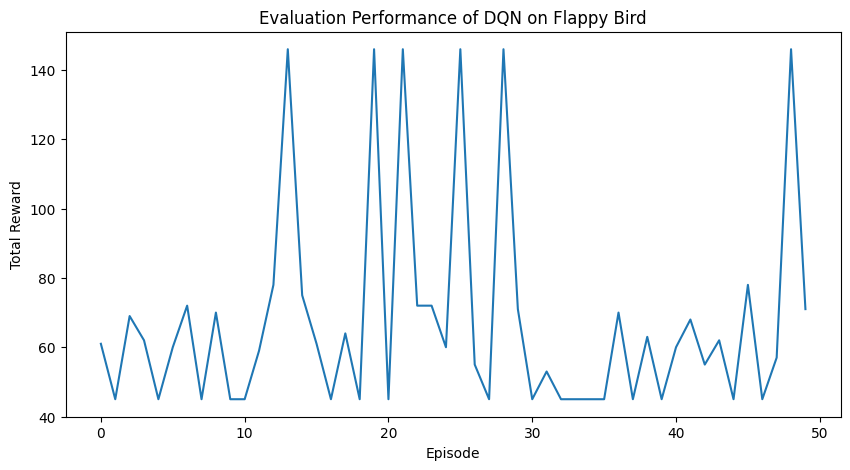

In [48]:
if __name__ == "__main__":
     # Plot training rewards
    plt.figure(figsize=(10, 5))
    plt.plot(train_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Performance of DQN on Flappy Bird')
    plt.show()

    # Plot evaluation rewards
    plt.figure(figsize=(10, 5))
    plt.plot(evaluation_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Evaluation Performance of DQN on Flappy Bird')
    plt.show()

**Results and Conclusion :**
After training the agent for 1000 episodes, the DQN was able to learn to navigate through the pipes with increasing efficiency. The average reward per episode improved significantly as training progressed, demonstrating the effectiveness of the DQN algorithm in playing Flappy Bird.